# Task 2: ideal pendulum
Sam Greydanus

In [12]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams.update({'font.size': 15})
import matplotlib.image as mpimg
import scipy.integrate
import pandas as pd
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-powergrid'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn,get_y0
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [13]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'powergrid',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

y0 = get_y0()
# y0 = np.array([1.1,0.1])
args = ObjectView(get_args())
np.random.seed(args.seed)

## Construct models

In [14]:
def get_model(args, model_name):
    baseline = True if model_name == "baseline" else False
    field_type = "damping" if model_name == "nhnn" else "solenoidal"
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=field_type, baseline=baseline)
    
    model_name = model_name
    path = "{}/powergrid{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [15]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [16]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [17]:
base_model = get_model(args,model_name='baseline')
hnn_model = get_model(args, model_name='hnn')
nhnn_model = get_model(args, model_name='nhnn')

In [18]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)


    nhnn_path = integrate_model(nhnn_model, t_span, x0, **kwargs)
    nhnn_x = nhnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    return true_x, base_x, hnn_x, nhnn_x


d_nhnn: tensor(0.0193, grad_fn=<SelectBackward0>)
(q_tau,p_tau) [1.00873497 0.0951782 ]


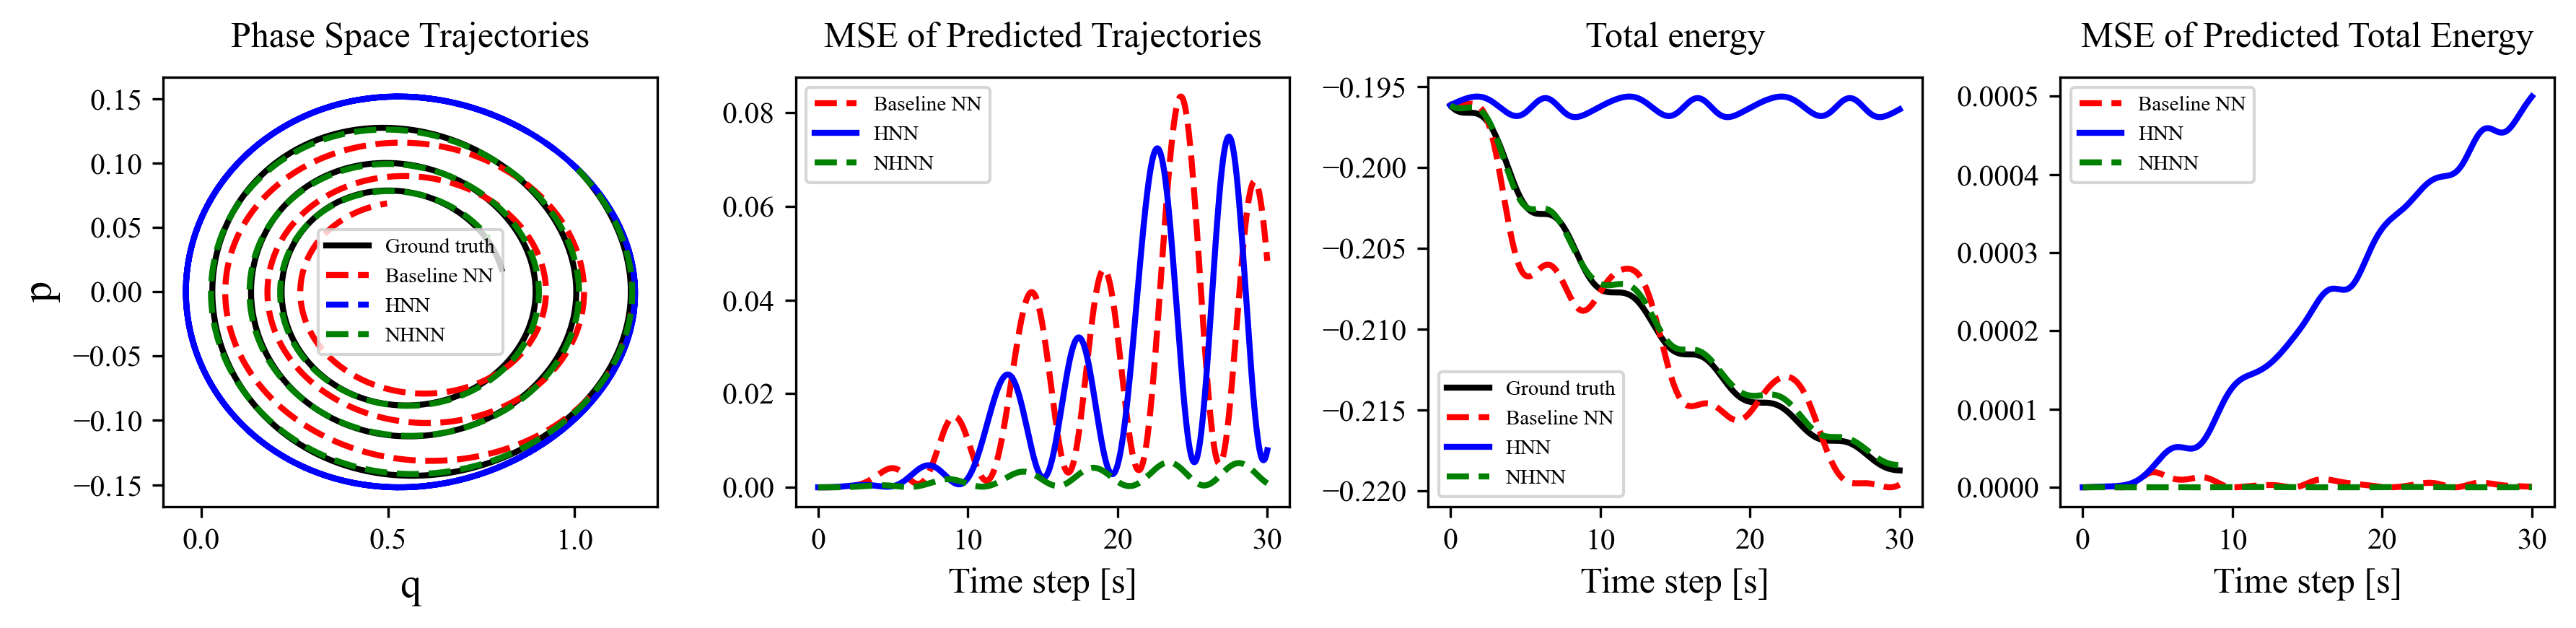

In [25]:
# x0 = np.asarray([0.5, 1.0]) 
d_nhnn = nhnn_model.linear.weight[1][1]
print('d_nhnn:', d_nhnn)
# x0 = y0

x0 = get_y0()
print('(q_tau,p_tau)', x0)

# integration
t_span=[0,30]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x, nhnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 10

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.rc('axes', labelsize=12)
plt.title("Phase Space Trajectories", pad=tpad) ; plt.xlabel('q') ; plt.ylabel('p')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r--', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b--', label='HNN', linewidth=2)
plt.plot(nhnn_x[:,0], nhnn_x[:,1], 'g--', label='NHNN', linewidth=2)
# plt.xlim(-0,2) ; plt.ylim(-0.5,0.5)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE of Predicted Trajectories", pad=tpad) ; plt.xlabel('Time step [s]')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r--', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='HNN', linewidth=2)
plt.plot(t_eval, ((true_x-nhnn_x)**2).mean(-1), 'g--', label='NHNN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step [s]')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
nhnn_e = np.stack([hamiltonian_fn(c) for c in nhnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r--', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='HNN', linewidth=2)
plt.plot(t_eval, nhnn_e, 'g--', label='NHNN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("MSE of Predicted Total Energy", pad=tpad) ; plt.xlabel('Time step [s]')
plt.plot(t_eval, ((true_e-base_e)**2), 'r--', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_e-hnn_e)**2), 'b-', label='HNN', linewidth=2)
plt.plot(t_eval, ((true_e-nhnn_e)**2), 'g--', label='NHNN', linewidth=2)
plt.legend(fontsize=7)
plt.tight_layout() ; plt.show()

# fig.savefig('{}/powergrid-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))



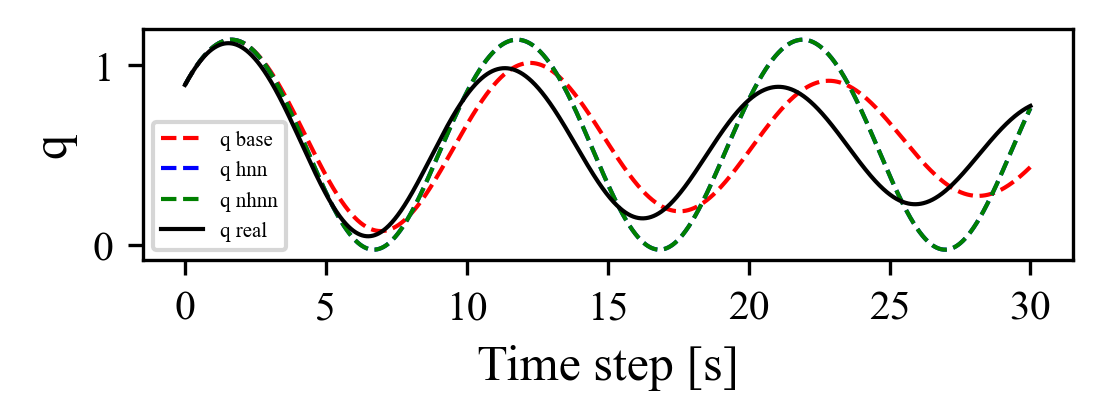

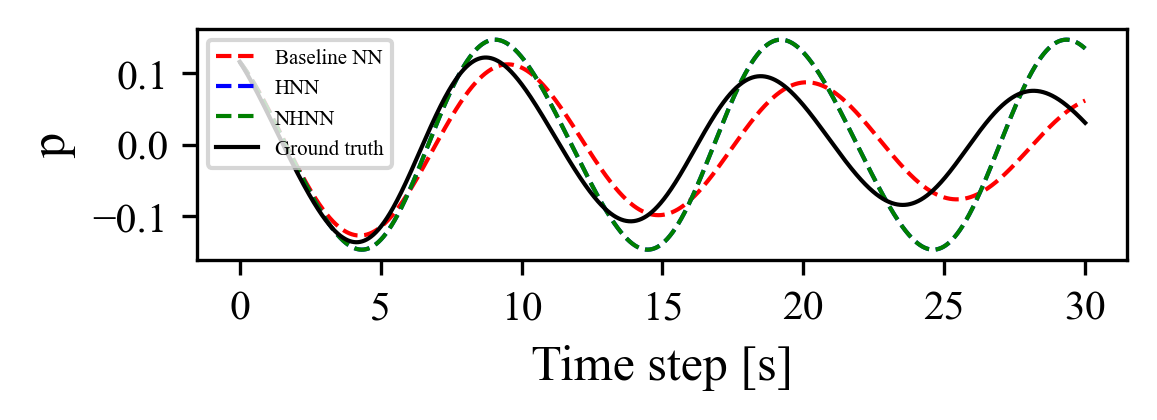

(<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>,
 None)

In [20]:
q_base = base_x[:,0]
p_base = base_x[:,1]
q_hnn = hnn_x[:,0]
p_hnn = hnn_x[:,1]
q_nhnn = hnn_x[:,0]
p_nhnn = hnn_x[:,1]
q_real = true_x[:,0]
p_real = true_x[:,1]

fig = plt.figure(figsize=(4, 1),facecolor='white', dpi=DPI)
plt.plot(t_eval, q_base, 'r--', label='q base', linewidth=1)
plt.plot(t_eval, q_hnn, 'b--', label='q hnn', linewidth=1)
plt.plot(t_eval, q_nhnn, 'g--', label='q nhnn', linewidth=1)
plt.plot(t_eval, q_real, 'k-', label='q real', linewidth=1)
plt.xlabel('Time step [s]')
plt.ylabel('q')
plt.legend(fontsize=5)
plt.tight_layout, plt.show()

fig = plt.figure(figsize=(4, 1),facecolor='white', dpi=DPI)
plt.plot(t_eval, p_base, 'r--', label='Baseline NN', linewidth=1)
plt.plot(t_eval, p_hnn, 'b--', label='HNN', linewidth=1)
plt.plot(t_eval, p_nhnn, 'g--', label='NHNN', linewidth=1)
plt.plot(t_eval, p_real, 'k-', label='Ground truth', linewidth=1)
plt.xlabel('Time step [s]')
plt.ylabel('p')
plt.legend(fontsize=5)

plt.tight_layout, plt.show()

In [21]:
# splits = 5
# samples = 3
# losses = {'base_energy' : [], 'hnn_energy' : []}
# t_eval = np.linspace(t_span[0], t_span[1], 100)

# _tmp = [] # for computing batched means
# for i in range(splits*samples):
#     x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
#     x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
#     true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    
#     losses['base_energy'] += [ energy_loss(true_x, base_x) ]
#     losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
#     print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [22]:
# losses = {k: np.array(v) for k,v in losses.items()}
# bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


# print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
#       .format(
#           np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
#           np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
#      )